# MSG project

In [1]:
import glob
import os
import pyart
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib
import pickle

%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# suppress anoying iypthon warnings. Not ideal since we suppress also potentially relevant warnings
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/exts-ml2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Auxiliary functions

In [3]:
# Function to read original dataset
# data is stored as (nz, ny, nx), we return (nx, ny)
def read_nc(fname):
    sat_grid = pyart.io.read_grid(fname)
    for field_name in sat_grid.fields.keys():
        data = np.transpose(np.squeeze(sat_grid.fields[field_name]['data']))
    return data        

In [4]:
# Function for minmax scaling
def minmax_scaling(data, vmin, vmax):
    data2 = deepcopy(data)
    data2[data2>vmax] = vmax
    data2[data2<vmin] =vmin
    return data2-vmin/(vmax-vmin)

In [5]:
# Filter data where IR temperature too high or channel differences too negative
def filter_data(X, y, ir_thr=240, diff_thr=-50):
    # Find row indexes of elements to delete
    ind = []
    ind_ir = np.where(X[:, 2] > ir_thr)
    if len(ind_ir[0]) > 0:
        ind.extend(ind_ir[0])
    ind_diff = np.where(X[:, 4] < diff_thr)
    if len(ind_diff[0]) > 0:
        ind.extend(ind_diff[0])
        
    # Remove NaNs
    # NaNs can appear in texture fields.
    # They could safely be considered 0s but we remove them
    for i in range(X.shape[1]):
        ind_nan = np.where(np.isnan(X[:, i]))
        if len(ind_nan[0]) > 0:
            ind.extend(ind_nan[0])
            
    if len(ind) == 0:
        return X, y
    
    ind = np.array(ind)
    ind = np.unique(ind)
    
    # delete from feature matrix
    X2 = np.delete(X, ind, axis=0)
    
    # delete from target matrix
    y2 = np.delete(y, ind, axis=0)
    
    print('removed '+str(len(ind))+' pixels out of '+str(y.size)+' from dataset')
    
    return X2, y2, ind

In [6]:
def plot_data(data, data_name, vmin=None, vmax=None, cmap=None, norm=None, ticks=None, ticklabs=None):
    fig = plt.figure()
    ax = plt.subplot()
    cax = ax.pcolormesh(data.T, vmin=vmin, vmax=vmax, cmap=cmap, norm=norm)
    ax.set_title(data_name)
    plt.axis('off')
    cb = fig.colorbar(cax)
    if ticks is not None:
        cb.set_ticks(ticks)
    if ticklabs is not None:
        cb.set_ticklabels(ticklabs)
    plt.show()

## Some global variables

In [7]:
fbasepath = '/data/pyrad_products/MSG_ML/'
features = ['HRV_norm', 'HRV_norm_text', 'IR_108', 'IR_108_text', 'WV_062-IR_108', 'WV_062-IR_108_text']
nfeatures = len(features)
target = 'POH90'

## Read input data

In [68]:
# dt_str = ['201908021110', '201808011735', '201805271615', '201906151420', '201907071410' 

dt_str = '201907071410'

feature_list = []
for feature in features:
    flist = glob.glob(fbasepath+'*/NETCDF/'+feature+'/'+dt_str+'*.nc')
    if len(flist) == 0:
        warn('Missing feature '+feature)
        break
    feature_list.append(read_nc(flist[0]))

## Plot input data and target

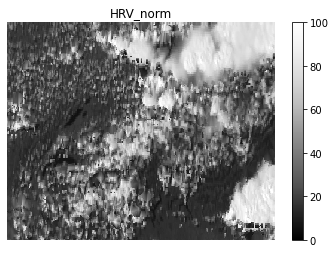

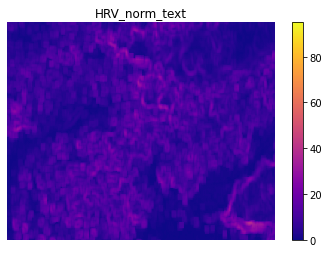

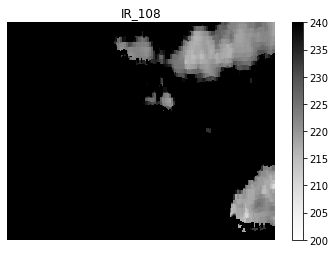

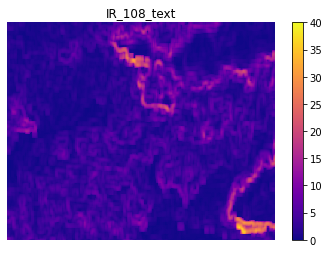

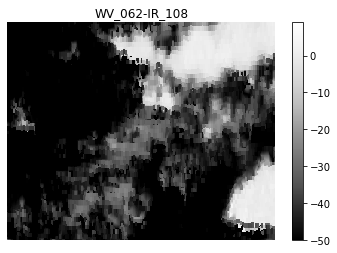

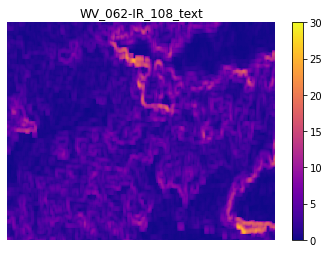

In [69]:
for feature_data, feature_name in zip (feature_list, features):
    if feature_name == 'HRV_norm':
        vmin = 0
        vmax = 100
        cmap = 'Greys_r'
    elif feature_name == 'HRV_norm_text':
        vmin = 0
        vmax = 95
        cmap = 'plasma'
    elif feature_name == 'IR_108':
        vmin = 200
        vmax = 240
        cmap = 'Greys'
    elif feature_name == 'IR_108_text':
        vmin = 0
        vmax = 40
        cmap = 'plasma'
    elif feature_name == 'WV_062-IR_108':
        vmin = -50
        vmax = 9
        cmap = 'Greys_r'
    elif feature_name == 'WV_062-IR_108_text':
        vmin = 0
        vmax = 30
        cmap = 'plasma'
    else:
        vmin= None
        vmax = None
        cmap = None
    plot_data(feature_data, feature_name, vmin=vmin, vmax=vmax, cmap=cmap)

In [70]:
flist = glob.glob(fbasepath+'*/NETCDF/'+target+'/'+dt_str+'*.nc')
target_data = read_nc(flist[0])

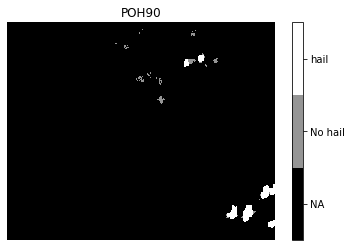

In [71]:
field_dict = {
    'ticks': [0, 1, 2],
    'boundaries': [-0.5, 0.5, 1.5, 2.5],
    'labels': ['NA', 'No hail', 'hail']
}

cmap = matplotlib.cm.get_cmap('Greys_r')
norm = matplotlib.colors.BoundaryNorm(
            boundaries=field_dict['boundaries'], ncolors=cmap.N)
plot_data(target_data, target, cmap=cmap, norm=norm, ticks=field_dict['ticks'], ticklabs=field_dict['labels'])

## Get input features

In [72]:
flist = glob.glob(fbasepath+'*/NETCDF/'+features[0]+'/'+dt_str+'*.nc')
img_size = read_nc(flist[0]).shape
data_size = img_size[0]*img_size[1]   

X = np.empty((data_size, nfeatures), dtype=np.float32)
for i, feature in enumerate(features):
    flist_aux = glob.glob(fbasepath+'*/NETCDF/'+feature+'/'+dt_str+'*.nc')
    data = read_nc(flist_aux[0]).flatten()
    X[:, i] = data
   
    flist_aux = glob.glob(fbasepath+'*/NETCDF/'+target+'/'+dt_str+'*.nc')
    y = np.transpose(read_nc(flist_aux[0]).flatten())

# Filter data
X, y, ind_filtered = filter_data(X, y)

removed 98957 pixels out of 114688 from dataset


In [73]:
# Group together 0 (No POH was computed) and 1 (POH below 90%)
np.unique(y)
y[y == 1] = 0
y[y == 2] = 1

## Get model

In [74]:
fname = 'balanced_RF_balanced_accuracy.pickle'
with open(fname, 'rb') as bfile:
    rf_model_best = pickle.load(bfile)

## Test model

In [75]:
# Report test score
acc_RF = 100*rf_model_best.score(X, y)
print('Test accuracy: {:.2f}%'.format(acc_RF))

Test accuracy: 71.03%


In [76]:
y_pred = rf_model_best.predict(X)

In [77]:
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

In [78]:
print('True positive: ', tp)
print('True negative: ', tn)
print('False positive: ', fp)
print('False negative: ', fn)
print('Positive pixels: ', y[y == 1].size)
print('Negative pixels: ', y[y == 0].size)

True positive:  794
True negative:  10380
False positive:  4527
False negative:  30
Positive pixels:  824
Negative pixels:  14907


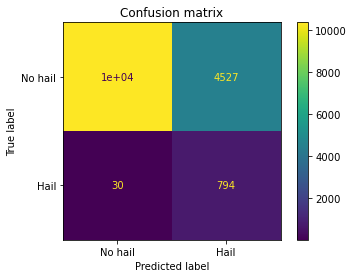

In [79]:
disp = plot_confusion_matrix(rf_model_best, X, y, labels=[0, 1], display_labels=['No hail', 'Hail'], normalize=None)
disp.ax_.set_title('Confusion matrix')
plt.show()

In [80]:
pod = 100*tp/(tp+fn)
far = 100*fp/(fp+tn)
ppv = tp/(tp+fp)
print('Probability of Detection (POD):', pod)
print('False Alarm Rate (FAR):', far)
print('Positive Predictive Value (PPV):', ppv)

Probability of Detection (POD): 96.35922330097087
False Alarm Rate (FAR): 30.368283356812235
Positive Predictive Value (PPV): 0.14922007141514754


## Visualize results

In [81]:
pred_data = np.ones(img_size, dtype=np.uint8).flatten()
pred_data[ind_filtered] = 0
pred_data = pred_data.reshape(img_size)
pred_data[pred_data == 1] = y_pred+1

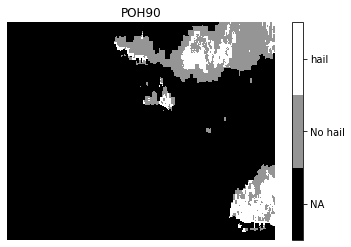

In [82]:
plot_data(pred_data, target, cmap=cmap, norm=norm, ticks=field_dict['ticks'], ticklabs=field_dict['labels'])